# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ====================== >>
Shape: (7000, (28, 28, 1), 2)
---------------------------------------
Train set size: 6000
Test set size: 1000
---------------------------------------
|    | dataset   | train     | test      |
|---:|:----------|:----------|:----------|
|  0 | 703 (1.1) | 603 (1.1) | 100 (1.3) |
|  1 | 795 (1.2) | 679 (1.2) | 116 (1.5) |
|  2 | 691 (1.1) | 612 (1.1) | 79 (1.0)  |
|  3 | 725 (1.1) | 609 (1.1) | 116 (1.5) |
|  4 | 645 (1.0) | 557 (1.0) | 88 (1.1)  |
|  5 | 640 (1.0) | 550 (1.0) | 90 (1.1)  |
|  6 | 729 (1.1) | 627 (1.1) | 102 (1.3) |
|  7 | 703 (1.1) | 605 (1.1) | 98 (1.2)  |
|  8 | 685 (1.1) | 577 (1.0) | 108 (1.4) |
|  9 | 684 (1.1) | 581 (1.1) | 103 (1.3) |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")
print(f"This can be seen in atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

                            Multidimensional feature  Target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       1
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       6
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       2
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       7
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       5

Every row in the column contains the data of one image, with shape: (28, 28, 1)
This can be seen in atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9354  Best f1_weighted: 0.9354
Time iteration: 18.521s   Total time: 18.525s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 1, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9197  Best f1_weighted: 0.9354
Time iteration: 4.558s   Total time: 23.209s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 1, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9324  Best f1_weighted: 0.9354
Time iteration: 4.551s   Total time: 27.787s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9447  Best f1_weighted: 0.9447
Time iteration: 8.954s   Total time: 36.752s
Initial point 5 ---------------------------------
Parameters --> {'e

## Analyze the results

In [8]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[1.5616496e-07, 5.3959901e-08, 2.1707820e-09, ..., 9.1047106e-05,
        5.5635996e-06, 5.1732041e-08],
       [9.9999964e-01, 1.5448963e-12, 2.1945819e-07, ..., 7.3680781e-09,
        1.8800412e-08, 1.1771864e-08],
       [4.5815549e-10, 3.0286182e-12, 5.4619996e-08, ..., 1.6488890e-05,
        6.6868910e-05, 3.9890820e-06],
       ...,
       [4.7990194e-09, 1.2956209e-09, 2.0525961e-13, ..., 2.4054803e-12,
        8.1172851e-07, 2.6179091e-06],
       [1.7111364e-03, 2.2890270e-10, 6.5999418e-05, ..., 1.2977836e-07,
        4.0744962e-06, 5.3302363e-09],
       [1.3362718e-03, 1.1138687e-05, 1.5611190e-03, ..., 8.9563131e-03,
        9.6595865e-01, 2.0727552e-02]], dtype=float32)

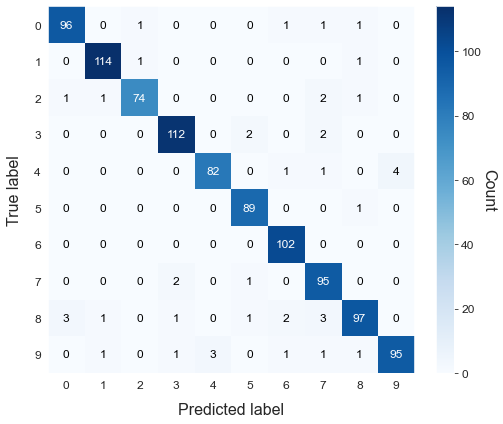

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()